# Clustering

Ce notebook a pour but de faire du clustering sur les données de la base de données. Nous avons d'abord fait un preprocessing des données pour pouvoir les utiliser dans les algorithmes de clustering. Nous avons ensuite comparé les résultats obtenus avec différentes méthodes de clustering.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import seaborn as sns



data_folder = os.path.join(os.getcwd(), '../data_original')
df = pd.read_csv(os.path.join(data_folder, 'users.csv'), sep=',')

In [2]:
df.head()

,ID acheteur,Softs_apresmidi,Softs_soir,Softs_matin,Softs_midi,Snacks Sucrés_apresmidi,Snacks Sucrés_soir,Snacks Sucrés_matin,Snacks Sucrés_midi,Pampryls_apresmidi,...,Bieres_matin,Bieres_midi,Fruits & Légumes_apresmidi,Fruits & Légumes_soir,Fruits & Légumes_matin,Fruits & Légumes_midi,prix_apresmidi,prix_soir,prix_matin,prix_midi
0,9447,43.0,4.0,11.0,40.0,20.0,3.0,8.0,13.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.939688,1.937261,0.745349,0.706111
1,9453,124.0,21.0,61.0,127.0,41.0,5.0,11.0,33.0,15.0,...,0.0,5.0,0.0,0.0,0.0,0.0,1.149896,1.792669,0.686705,0.698964
2,9701,53.0,21.0,4.0,46.0,36.0,0.0,3.0,12.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.811579,1.657937,0.724194,0.727895
3,9603,21.0,4.0,17.0,21.0,21.0,0.0,2.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.163214,1.781368,0.662500,0.607143
4,12024,4.0,4.0,0.0,9.0,9.0,6.0,5.0,19.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.731818,1.024500,0.813043,0.558667


## 1. Preprocessing

### 1.1. Normalisation

Cette étape consiste à normaliser les données pour que les données ne soient pas biaisées par les unités de mesure. Nous avons utilisé la méthode RobustScaler de sklearn qui permet de normaliser les données en utilisant la médiane et le quartile au lieu de la moyenne et de l'écart-type. Cela permet de ne pas être sensible aux valeurs aberrantes.

In [3]:
# On normalise toutes les colonnes sauf l'ID acheteur
X = df[df.columns[1:]].values

scaler = RobustScaler()
X = scaler.fit_transform(X)

df[df.columns[1:]] = X

### 1.2. Réduction de dimension

In [4]:
column_names = df.columns[1:]

selector = VarianceThreshold(threshold=0.2)
X = selector.fit_transform(X)

removed_columns = column_names[~selector.get_support()]

print("Columns after variance threshold:", X.shape[1])
print("Removed columns:", removed_columns)


Columns after variance threshold: 38
Removed columns: Index(['Bieres_matin', 'Bieres_midi'], dtype='object')


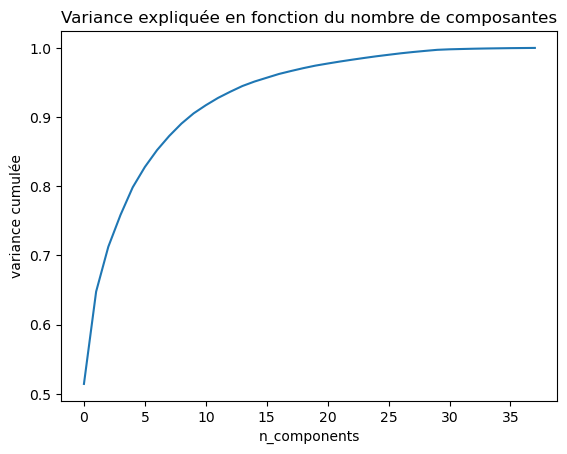

Nb features pour 95% de variance expliquée: 15


In [5]:
# PCA, on veut merge des features, tout en conservant un maximum de variance expliquée
# car c'est ce qui permet de différencier les clusters

model = PCA(n_components=38)
X_copy = X.copy()

X_copy = model.fit_transform(X_copy)

cumsum = model.explained_variance_ratio_.cumsum()
plt.plot(cumsum)
plt.title("Variance expliquée en fonction du nombre de composantes")
plt.xlabel("n_components")
plt.ylabel("variance cumulée")
plt.show()

print(f"Nb features pour 95% de variance expliquée: {np.argmax(cumsum >= 0.95) + 1}")

In [6]:
model = PCA(n_components=15)
X = model.fit_transform(X)


## 2. Clustering

### 2.1. Comparaison des différents algorithmes

In [7]:
scores = dict()
d_scores = dict()
c_scores = dict()

clustering_algorithms = [
        KMeans(),
        AgglomerativeClustering(),
        DBSCAN(),
        SpectralClustering()
    ]

for algorithm in clustering_algorithms:
    scores[algorithm.__class__.__name__] = []
    d_scores[algorithm.__class__.__name__] = []
    c_scores[algorithm.__class__.__name__] = []

for k in tqdm(range (2, 7)):
    clustering_algorithms = [
        KMeans(n_clusters=k, n_init="auto"),
        AgglomerativeClustering(n_clusters=k),
        DBSCAN(eps=0.5, min_samples=k),
        SpectralClustering(n_clusters=k, affinity='nearest_neighbors')
    ]

    for algorithm in clustering_algorithms:
        algorithm.fit(X)
        labels = algorithm.labels_
        score = silhouette_score(X, labels)
        d_score = davies_bouldin_score(X, labels)
        c_score = calinski_harabasz_score(X, labels)
        # print(f"Algorithm: {algorithm.__class__.__name__}, Silhouette Score: {score}")

        scores[algorithm.__class__.__name__].append(score)
        d_scores[algorithm.__class__.__name__].append(d_score)
        c_scores[algorithm.__class__.__name__].append(c_score)


  0%|          | 0/5 [00:00<?, ?it/s]/home/theo/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 20%|██        | 1/5 [00:35<02:23, 35.84s/it]/home/theo/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 40%|████      | 2/5 [01:02<01:31, 30.44s/it]/home/theo/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 60%|██████    | 3/5 [01:25<00:53, 26.90s/it]/home/theo/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
 80%|████████  | 4/5 [01:46<00:24, 24.67

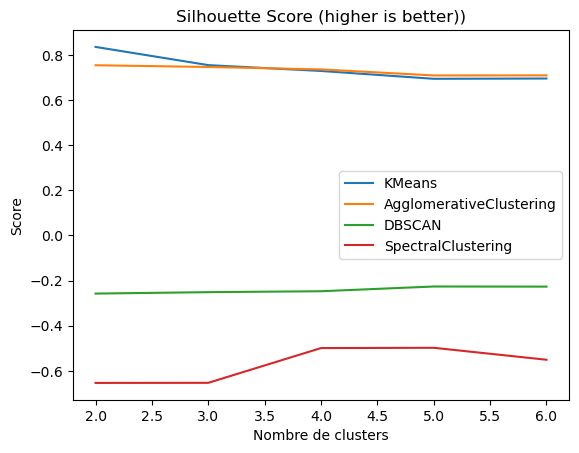

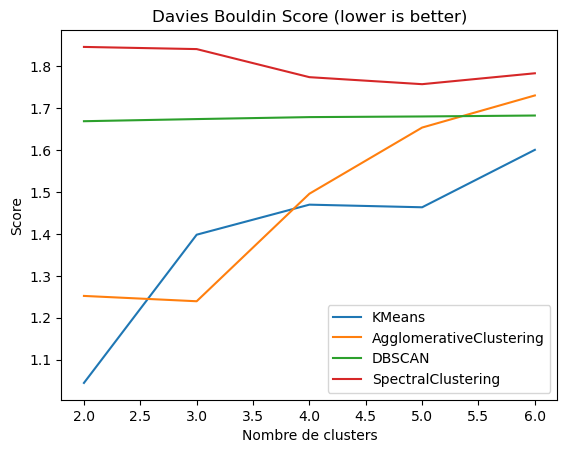

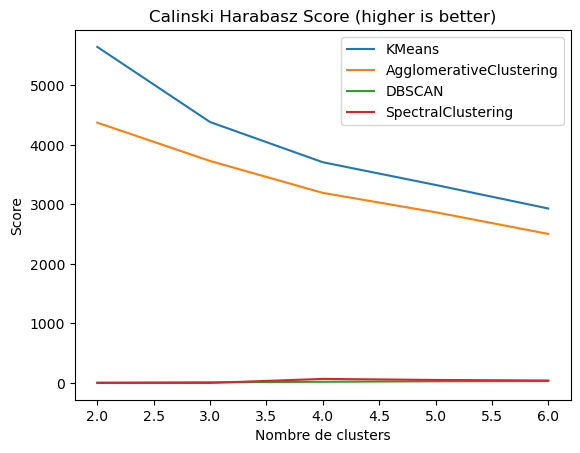

In [8]:
# affichage des scores
for algorithm in scores:
    plt.plot(range(2, 7), scores[algorithm], label=algorithm)
plt.title("Silhouette Score (higher is better)")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score")
plt.legend()
plt.show()

for algorithm in d_scores:
    plt.plot(range(2, 7), d_scores[algorithm], label=algorithm)
plt.title("Davies Bouldin Score (lower is better)")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score")
plt.legend()
plt.show()

for algorithm in c_scores:
    plt.plot(range(2, 7), c_scores[algorithm], label=algorithm)
plt.title("Calinski Harabasz Score (higher is better)")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score")
plt.legend()
plt.show()




On peut voir que KMeans a l'air d'être le plus performant.

### Test de la performance du modèle

Il est maintenant intéressant de cherchant quels sont les paramètres qui offrent la meilleur performance : on cherche le nombre de clusters 

Pour trouver le nombre idéal de cluster, nous allons utiliser la **elbow method** : on va tracer l'évolution du coût de notre modèle en fonction du nombre de clusters et on va ensuite détecter dans le graphique une zone de coude optimale

Text(0, 0.5, 'Coût du modèle (inertia)')

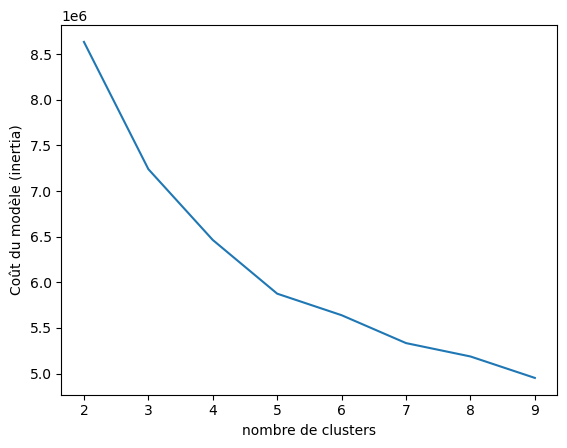

In [9]:
inertia = []
K_range = range(2,10)
for k in K_range:
    model = KMeans(n_clusters=k, n_init="auto")
    model.fit(X)
    inertia.append(model.inertia_)

plt.plot(K_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('Coût du modèle (inertia)')


On commence par construire une grille de modèles avec toutes les combinaisons d'hyperparamètres possibles :
    - le nombre de clusters 
    - les différentes méthodes d'initialisation
    - le nombre d'initialisation différentes
    - le nombre maximum d'iteration 
    - les algorithmes à utiliser 
    

### 2.2 KMeans

Après avoir trouvé le nombre de clusters optimal, et avoir comparé les différents algorithmes, nous avons choisi d'utiliser KMeans. Il est maintenant intéressant de chercher quels sont les paramètres qui offrent la meilleur performance à l'aide de gridsearch.

In [10]:
param_grid = {
    'n_clusters': [3],
    'init': ['random', 'k-means++'],  # Méthodes d'initialisation
    "n_init": [10, 20, 30, "auto"]  # Nombre d'initialisations
}

In [11]:
# On cherche maintenant les hyperparamètres
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(KMeans(), param_grid, cv=5)
grid.fit(X)
print(grid.best_params_)
print(grid.best_score_)

model = KMeans(**grid.best_params_)


{'init': 'k-means++', 'n_clusters': 3, 'n_init': 'auto'}
-1518453.9640547365


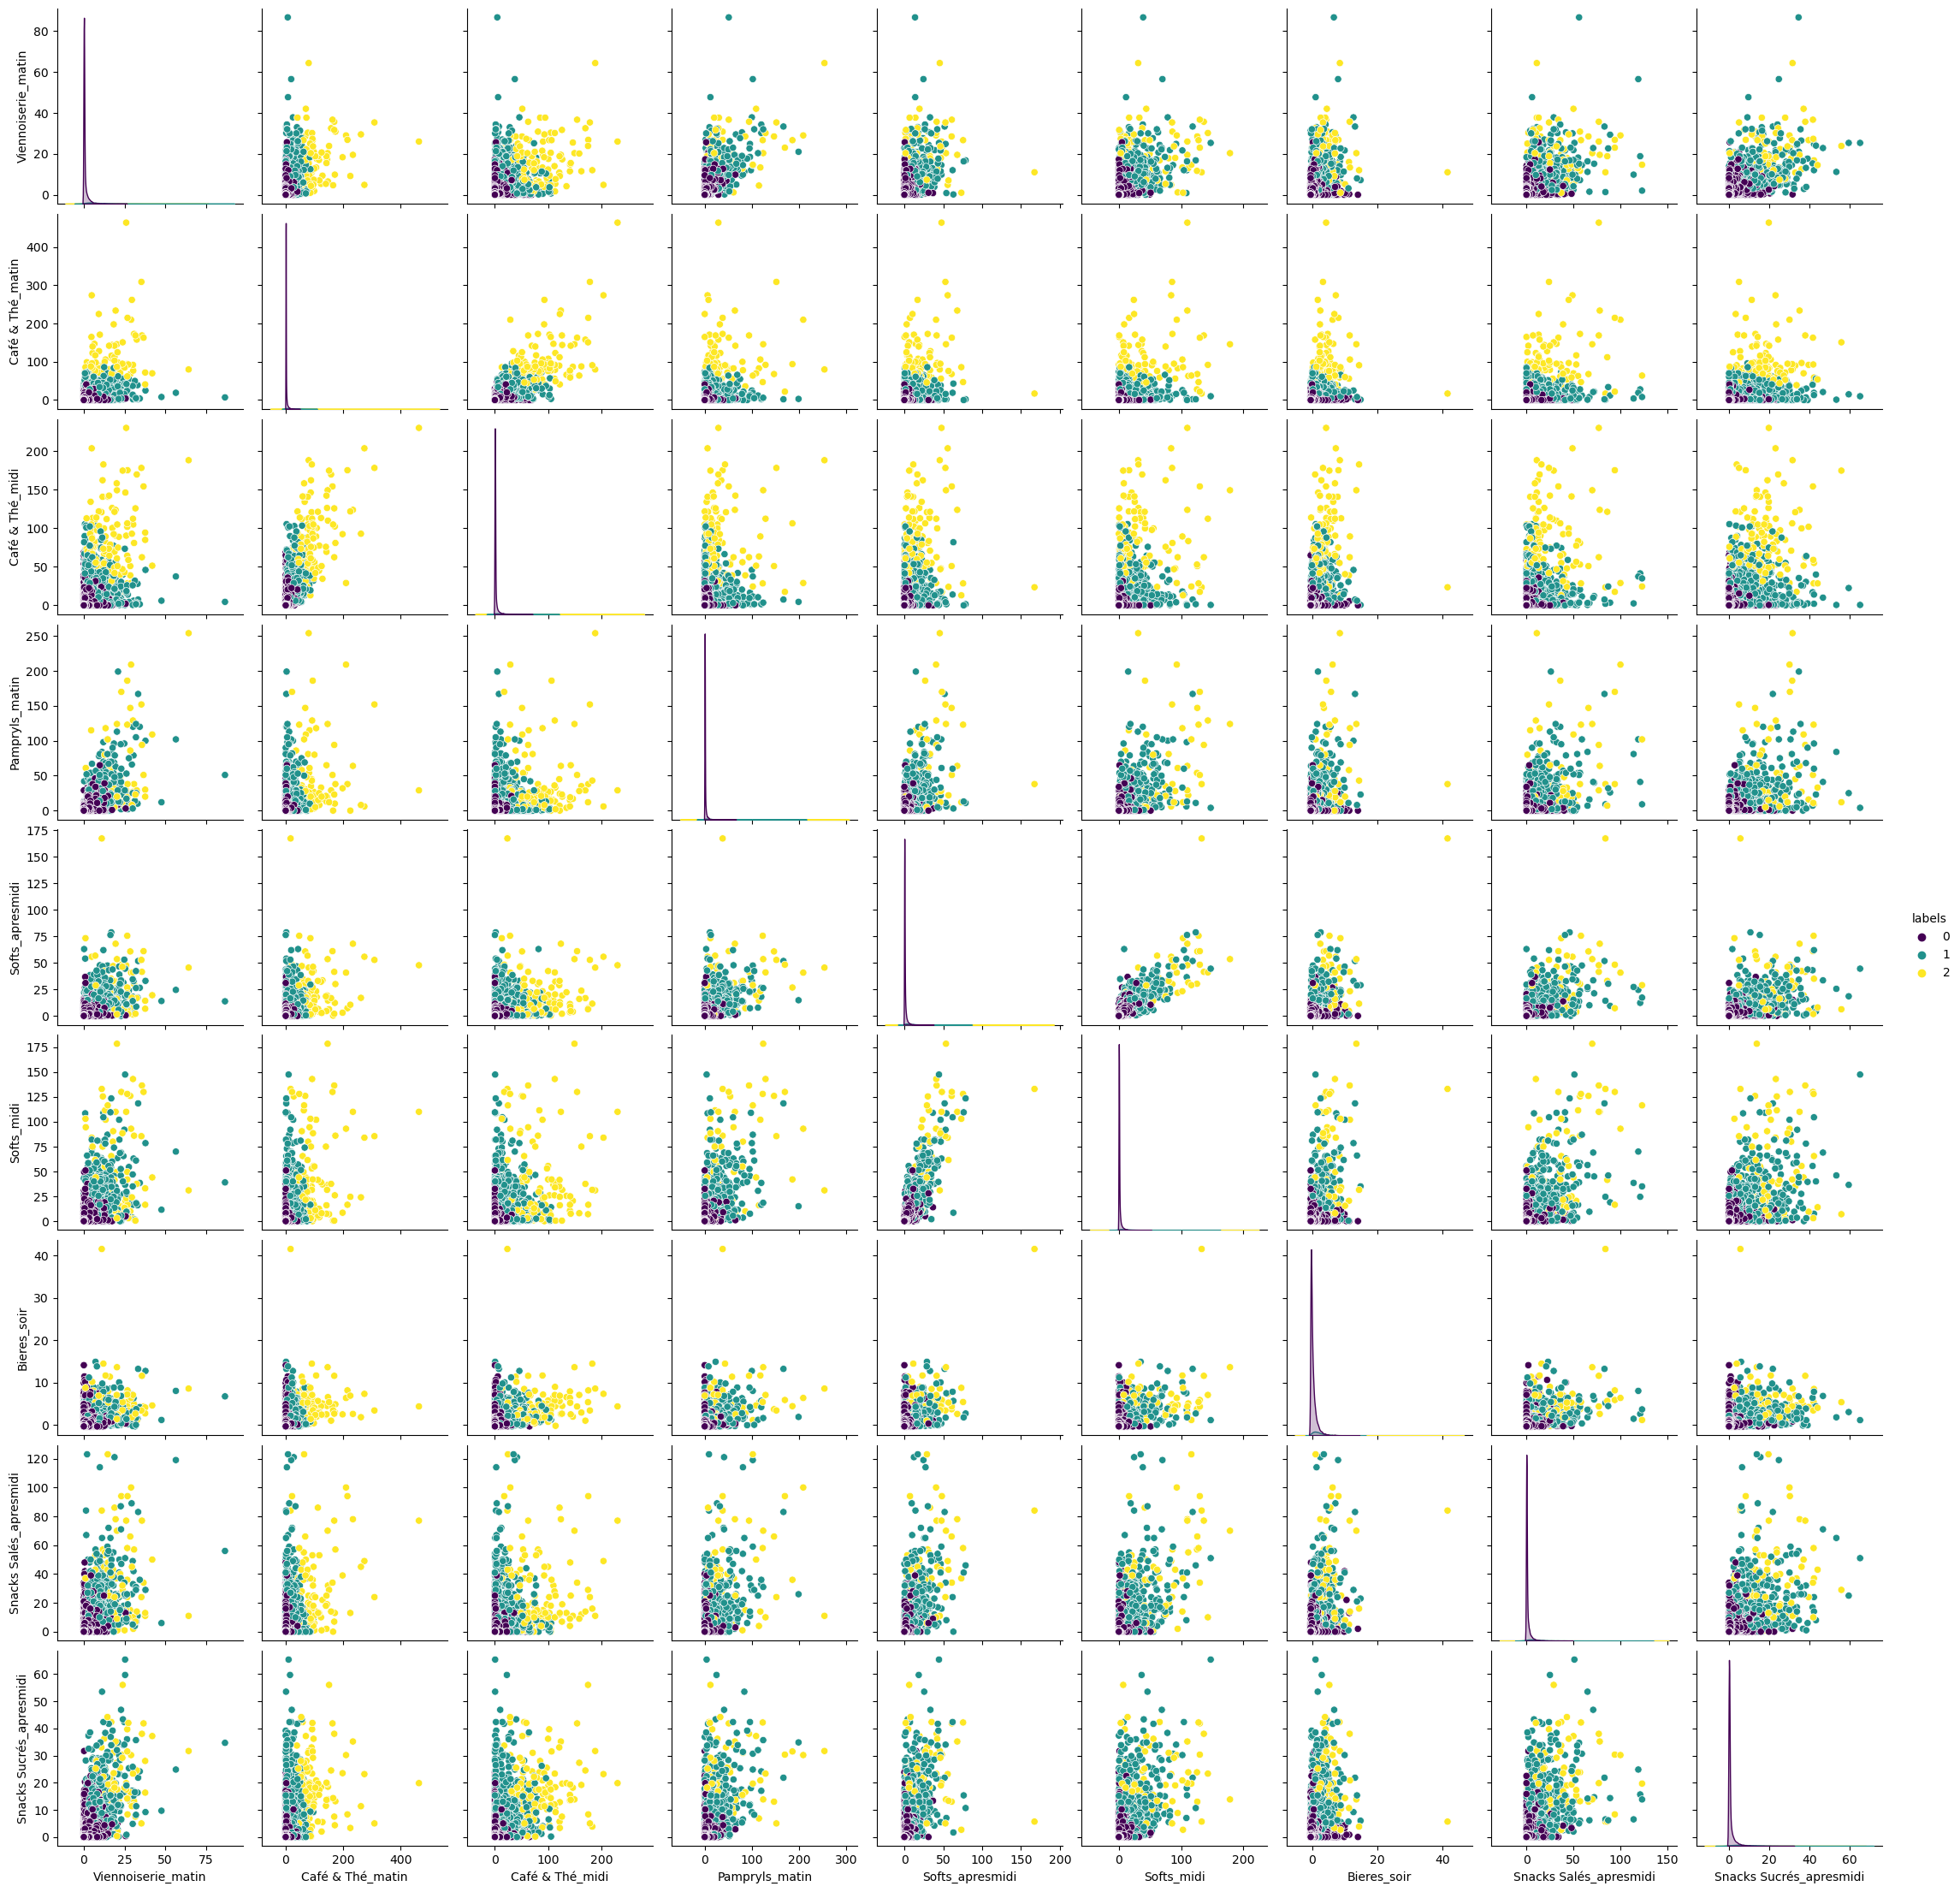

In [12]:
labels = model.fit_predict(X)

df['labels'] = labels  # Add 'labels' column to the dataframe

cols = ["Viennoiserie_matin", 'Café & Thé_matin', 'Café & Thé_midi', 'Pampryls_matin', "Softs_apresmidi", "Softs_midi", "Bieres_soir", "Snacks Salés_apresmidi", "Snacks Sucrés_apresmidi", "labels"]

sns.pairplot(df[cols], hue='labels', palette='viridis')


Nous pouvons voir qu'il existe bien des clusters, mais que ceux-ci ne se caractérisent pas par la nature des consommations, mais plutôt par les quantités.